# Creating GIF animation of a moving pendulum with CKS

In the meantime, refer to the preprint for the physics: [https://arxiv.org/abs/2504.16816](https://arxiv.org/abs/2504.16816)

## Defining the physics and the CKS

The python code belows define the CKS which will be called later during the angular trajectory generations.

In [38]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

def K_exact(k):
    # scipy defines K differently, so that we need to pass k**2 insead of k
    return sp.special.ellipk(k**2)

def K_thiswork(k):
    n = (np.log(4) - np.log(np.pi))/(np.pi/2 - np.log(4))
    b = np.exp(n*np.pi/2) - 4**n
    return 1/n*np.log( (4/np.sqrt(1-k**2))**n + b)

#mode='exact'
mode='accurate'

def K(k):
    if mode=='exact': return K_exact(k)
    if mode=='accurate': return K_thiswork(k)
    
# compute magnitude of omegac
def get_omegac(g, L):
    return 2*np.sqrt(g/L)

# compute magnitude of omegaM
def get_omegaM(theta0, omega0, g, L):
    return np.sqrt(omega0**2 - 2*g/L*np.cos(theta0) + 2*g/L)

# compute omega0 consistent with stoppig motion
def get_omega0c(theta0, g, L):
    omegac = get_omegac(g, L)
    return np.sqrt(omegac**2 + 2*g/L*np.cos(theta0) - 2*g/L)

# compute phase shift for CKS
def phase_CKS(theta0, omega0, g, L, cutoff=1e-8, maxN=20):
    
    # special cases
    if theta0 == 0.0: return 0.0
    if omega0 == 0.0:
        if theta0 > 0: return +np.pi/2
        else: return -np.pi/2

    omegac = get_omegac(g, L)
    omegaM = get_omegaM(theta0, omega0, g, L)
    
    # swinging motion
    if omegaM < omegac:
                
        # compute coefficient an
        k = np.sqrt(L/g)*omegaM/2
        kappa = K(np.sqrt(1-k**2))/K(k)

        a = np.zeros(maxN)
        for j in range(1,maxN,2):
            a[j] = 4/j/np.cosh(kappa*j*np.pi/2)

        def f(delta):
            s = 0
            for j in range(1,maxN,2): s = s + a[j]*np.sin(j*delta)
            return theta0 - s

        def fp(delta):
            s = 0
            for j in range(1,maxN,2): s = s + j*a[j]*np.cos(j*delta)
            return -s

        # initial guess
        delta = np.arcsin(theta0/a[1])

        # update
        while True:
            step = - f(delta)/fp(delta)
            delta = delta + step
            if np.abs(step) < cutoff: break
                
    # stopping motion, omegaM == omegac
    elif np.abs(omegaM-omegac) < 1e-12:
        x = np.sin(theta0/2)
        delta = 1/2*np.log((1+x)/(1-x))
        
    # spining motion
    else:
        
        # compute coefficients
        b = np.zeros(maxN)
        k = np.sqrt(L/g)*omegaM/2
        kappa = K(np.sqrt(1-1/k**2))/K(1/k)
        for n in range(1,maxN):
            b[n] = 2/n/np.cosh(n*np.pi*kappa)

        def f(delta):
            s = 0
            for j in range(1,maxN,1): s = s + b[j]*np.sin(j*delta)
            return theta0 - delta - s

        def fp(delta):
            s = 0
            for j in range(1,maxN,1): s = s + j*b[j]*np.cos(j*delta)
            return -1-s
        
        # initial guess
        delta = theta0/(1+b[1])

        # update
        while True:
            step = - f(delta)/fp(delta)
            delta = delta + step
            if np.abs(step) < cutoff: break

    return delta

##
## the Chiang Khruea solutions (CKS)
##
def theta_CKS(theta0, omega0, t, g, L, maxN=20):
    
    theta = np.zeros(len(t))
    
    omegac = get_omegac(g, L)
    omegaM = get_omegaM(theta0, omega0, g, L)

    # For omega0 < 0, use mirror symmetry
    if omega0 < 0:
        theta0 = -theta0
        omega0 = -omega0
        mirror = True
    else:
        mirror = False
        
    # compute phase constant
    delta = phase_CKS(theta0, omega0, g, L, 1e-8, maxN)
    
    # swinging motion
    if omegaM < omegac:

        # compute period
        k = np.sqrt(L/g)*omegaM/2
        T = 4*np.sqrt(L/g)*K(k)

        # compute coefficients
        a = np.zeros(maxN)
        kappa = K(np.sqrt(1-k**2))/K(k)
        for n in range(1,maxN,2):
            a[n] = 4/n/np.cosh(kappa*n*np.pi/2)
        
        # sum contributions at time t
        for i in range(len(t)):
            s = 0
            for n in range(0,maxN): s = s + a[n]*np.sin(2*n*np.pi/T*t[i] + n*delta)
            theta[i] = s
    
    # stopping motion, omegaM == omegac
    elif np.abs(omegaM-omegac) < 1e-12:
        for i in range(len(t)):
            theta[i] = 2*np.arcsin( np.tanh(np.sqrt(g/L)*t[i] + delta) )
    
    # spinning motion
    else:
        # compute period
        k = np.sqrt(L/g)*omegaM/2
        T = 2*np.sqrt(L/g)/k*K(1/k)
        
        # compute coefficients
        b = np.zeros(maxN)
        kappa = K(np.sqrt(1-1/k**2))/K(1/k)
        for n in range(1,maxN):
            b[n] = 2/n/np.cosh(n*np.pi*kappa)
        
        # sum contributions at time t + 
        for i in range(len(t)):
            s = 0
            for n in range(0,maxN): s = s + b[n]*np.sin(2*n*np.pi/T*t[i] + n*delta)
            theta[i] = 2*np.pi/T*t[i] + delta + s

    if mirror == True: return -theta
    else: return theta


## Generate angular trajectory

You may choose the initial conditions $(\theta_0, \omega_0)$, and physics parameters like $g, L$ here. A recomended choice is presented here, but you may use any values you desire. 

Tmax 4.29883390061438
NFRAME 400


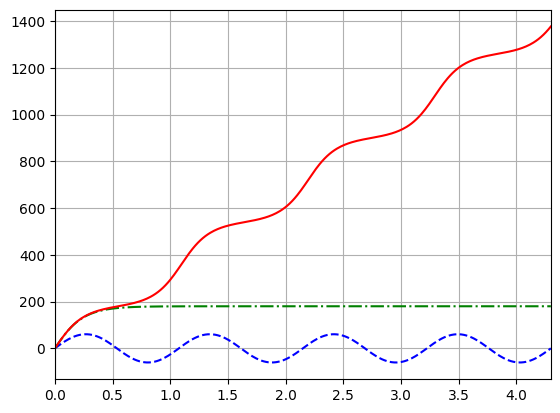

In [39]:
# using one-second linear pendulum
g = 9.8
L = g/4/np.pi**2

k = np.sqrt(L/g)*((4*np.pi+0.1)/2)/2
T = 4*np.sqrt(L/g)*K(k)

Tmax = 4*T
t = np.linspace(0, Tmax, 400)
print('Tmax', Tmax)
print('NFRAME',len(t))

swingingTheta = theta_CKS(0,(4*np.pi+0.1)/2,t,g,L)
stoppingTheta = theta_CKS(0,4*np.pi,t,g,L)
spinningTheta = theta_CKS(0,4*np.pi+0.1,t,g,L)

plt.plot(t, 180/np.pi*swingingTheta,'b--',label='Swinging:  $\\omega_m < \\omega_c$')
plt.plot(t, 180/np.pi*stoppingTheta,'g-.',label='Stopping:  $\\omega_m = \\omega_c$')
plt.plot(t, 180/np.pi*spinningTheta,'r-', label='Spinning:  $\\omega_m > \\omega_c$')
#plt.ylim(-180,1440)
plt.xlim(0, Tmax)
plt.grid()
plt.show()

In [40]:
############
# Animation
############

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc


fig, ax = plt.subplots()
plt.close()

R = 100

def animate(t):

  ax.clear()
  x =  R*np.sin(swingingTheta[t])
  y = -R*np.cos(swingingTheta[t])
  swingCircle = plt.Circle( (x, y), 10, color='blue')
  swingArrow = plt.Arrow(0, 0, x, y, width=2)
  ax.add_patch(swingCircle)
  ax.add_patch(swingArrow)

  x =  R*np.sin(spinningTheta[t])
  y = -R*np.cos(spinningTheta[t])
  spinCircle = plt.Circle( (x, y), 10, color='red')
  spinArrow = plt.Arrow(0, 0, x, y, width=2)
  ax.add_patch(spinCircle)
  ax.add_patch(spinArrow)

  x =  R*np.sin(stoppingTheta[t])
  y = -R*np.cos(stoppingTheta[t])
  stopCircle = plt.Circle( (x, y), 10, color='green')
  stopArrow = plt.Arrow(0, 0, x, y, width=2)
  ax.add_patch(stopCircle)
  ax.add_patch(stopArrow)

  ax.set_ylim([-150,+150])
  ax.set_xlim([-150,+150])
  ax.set_aspect('equal')

  ax.set_title('3 Classes of Nonlinear Pendulum Motion')
  ax.set_yticks([])
  ax.set_xticks([])
  ax.grid()
  ax.text(0,120,"Stopping",color="green")
  ax.text(0,-125,"Swinging",color="blue")
  ax.text(-100,0,"Spinning",color="red")

anim = animation.FuncAnimation(fig, animate, frames=400)
anim.save('CKS_solution.gif', fps=20)